##### Lazımi kitabxanaların daxil edilməsi

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

##### Datasetin yüklənməsi

In [ ]:
from tensorflow.keras.datasets import mnist
print("Datasetin yüklənməsi...")
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Datasetin yüklənməsi...


##### Datanın normallaşdırılması

In [25]:
train_images = train_images.reshape(-1, 28, 28, 1).astype('float32') / 255.0
test_images = test_images.reshape(-1, 28, 28, 1).astype('float32') / 255.0

print(f"Train datasetin ölçüsü: {len(train_images)}")
print(f"Test datasetin ölçüsü: {len(test_images)}")

Train datasetin ölçüsü: 60000
Test datasetin ölçüsü: 10000


##### Datasetdən bəzi nümunələr

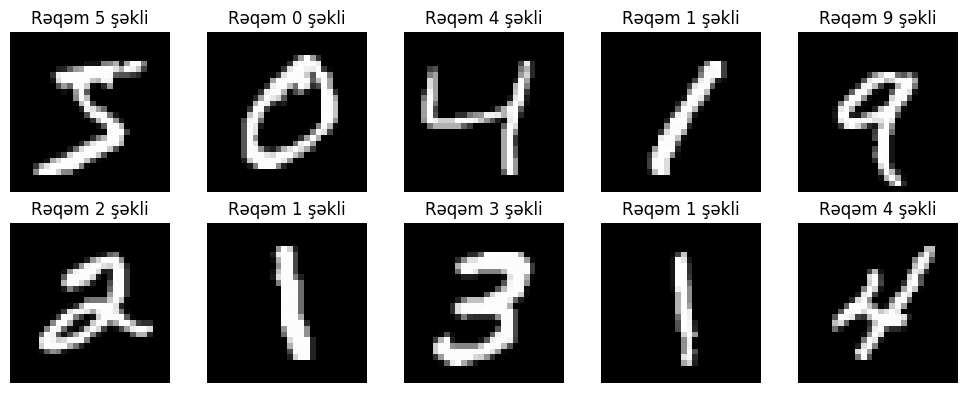

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    if i < 10:
        ax.imshow(train_images[i].squeeze(), cmap='gray')
        ax.set_title(f'Rəqəm {train_labels[i]} şəkli')
        ax.axis('off')
plt.tight_layout()
plt.show()

##### Modelin yaradılması

In [27]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', input_shape=(28, 28, 1)),
    layers.ReLU(),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (3, 3)),
    layers.ReLU(),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    
    layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'),
    layers.ReLU(),
    layers.Dropout(0.4),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(10, activation='softmax')
])

c:\Users\User\OneDrive\Desktop\serbest_ish\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
model.save('my_model.h5')

In [28]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 13, 13, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6, 6, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1, 1, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 1, 1, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,874 (394.04 KB)

 Trainable params: 100,554 (392.79 KB)

 Non-trainable params: 320 (1.25 KB)

##### Modelin kompilyasiya etmək

In [29]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

##### Trainin başladılması

In [30]:
print("Train başlandı...")
history = model.fit(train_images, train_labels,
                    epochs=5,
                    batch_size=64,
                    validation_data=(test_images, test_labels))
print("Train başa çatdı.")

Train başlandı...
Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 78s 78ms/step - accuracy: 0.8703 - loss: 0.4145 - val_accuracy: 0.9811 - val_loss: 0.0581
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 70s 75ms/step - accuracy: 0.9659 - loss: 0.1259 - val_accuracy: 0.9872 - val_loss: 0.0443
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 83s 89ms/step - accuracy: 0.9734 - loss: 0.0987 - val_accuracy: 0.9896 - val_loss: 0.0361
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 71s 76ms/step - accuracy: 0.9764 - loss: 0.0854 - val_accuracy: 0.9908 - val_loss: 0.0327
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 70s 74ms/step - accuracy: 0.9796 - loss: 0.0752 - val_accuracy: 0.9907 - val_loss: 0.0343
Train başa çatdı.


##### Model təlim prosesin vizualı

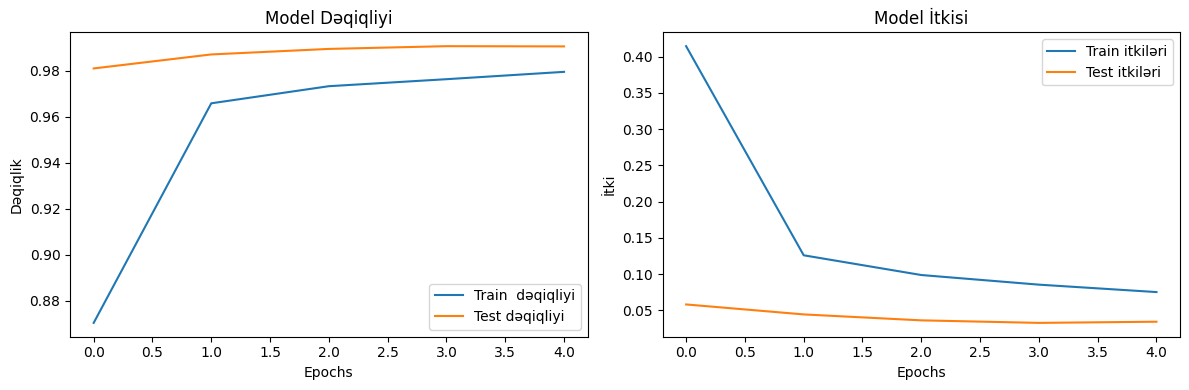

In [31]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train  dəqiqliyi')
plt.plot(history.history['val_accuracy'], label='Test dəqiqliyi')
plt.xlabel('Epochs')
plt.ylabel('Dəqiqlik')
plt.title('Model Dəqiqliyi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train itkiləri')
plt.plot(history.history['val_loss'], label='Test itkiləri')
plt.xlabel('Epochs')
plt.ylabel('İtki')
plt.title('Model İtkisi')
plt.legend()

plt.tight_layout()
plt.show()

##### Modelin test olunması

In [32]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"\nTest dəqiqliyi: {test_accuracy*100:.2f}%")

predictions = model.predict(test_images)
pred_labels = np.argmax(predictions, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9907 - loss: 0.0343

Test dəqiqliyi: 99.07%
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


##### Confusion(qarışıqlıq) maxrixin çap olunması

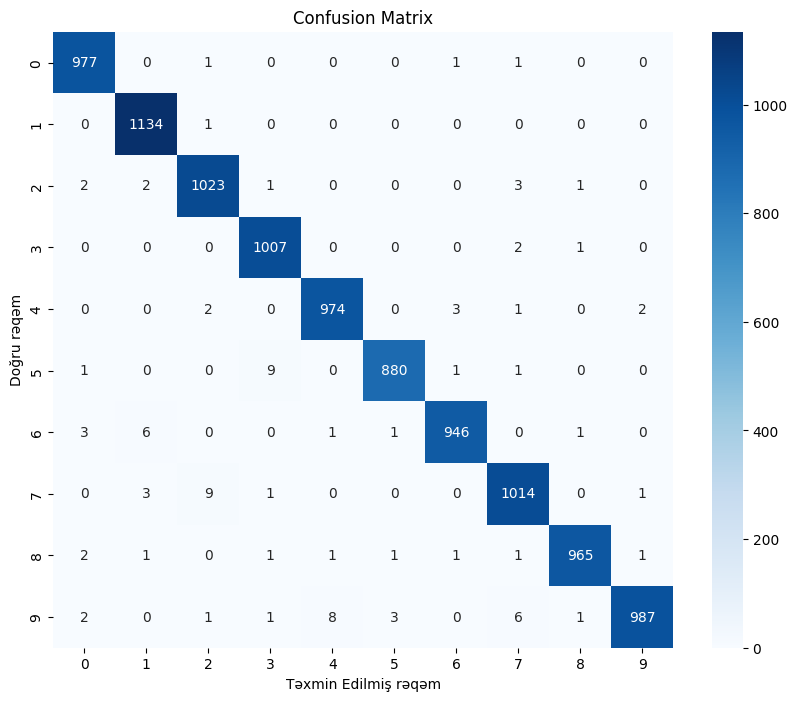

In [33]:
conf_matrix = confusion_matrix(test_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Təxmin Edilmiş rəqəm')
plt.ylabel('Doğru rəqəm')
plt.title('Confusion Matrix')
plt.show()

##### Bəzi təsadüfi elementlərin çap olunması

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


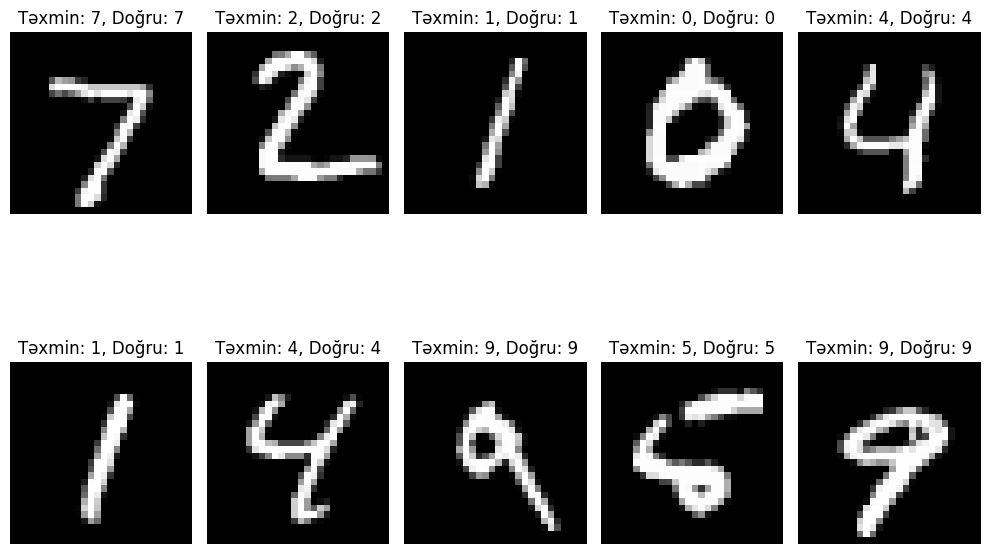

In [34]:
sample_images = test_images[:10]
sample_predictions = model.predict(sample_images)
pred_labels = np.argmax(sample_predictions, axis=1)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
    if i < len(sample_images):
        ax.imshow(sample_images[i].squeeze(), cmap='gray')
        ax.set_title(f'Təxmin: {pred_labels[i]}, Doğru: {test_labels[i]}')
        ax.axis('off')
plt.tight_layout()
plt.show()

##### Səhv təxmin olunmuş bəzi nümumələr

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


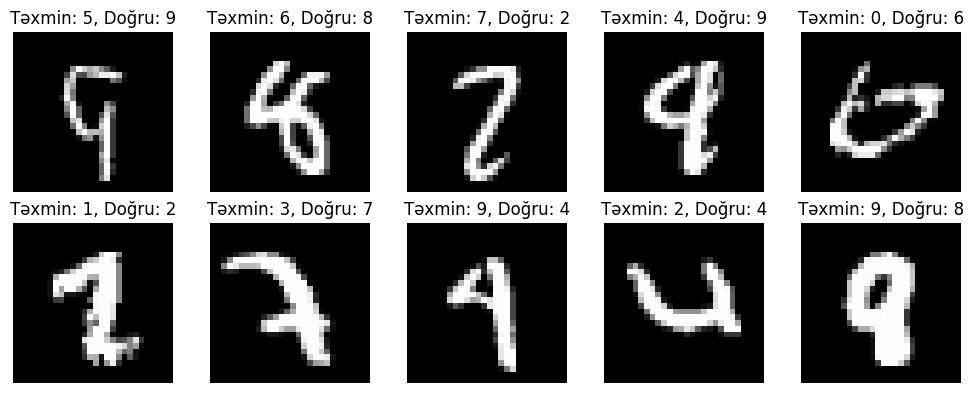

In [35]:
predictions = model.predict(test_images)
pred_labels = np.argmax(predictions, axis=1)
misclassified_idx = np.where(pred_labels != test_labels)[0][:10]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    if i < len(misclassified_idx):
        idx = misclassified_idx[i]
        ax.imshow(test_images[idx].squeeze(), cmap='gray')
        ax.set_title(f'Təxmin: {pred_labels[idx]}, Doğru: {test_labels[idx]}')
        ax.axis('off')
plt.tight_layout()
plt.show()